### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper,shrinkBigKTransformer,logminus_T,exp_T,logminplus1_T,none_T, logp1_T,missingValHandler,dropConst
import os
import pandas as pd

In [2]:
import daal4py.sklearn
daal4py.sklearn.patch_sklearn()

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [3]:

from warnings import filterwarnings
filterwarnings('ignore')


In [4]:
test_share=0.2 
cv_folds=5
cv_reps=5
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [5]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [6]:
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [7]:
include_intercept=1

In [8]:
# add interaction terms

In [9]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

In [10]:
n,k=X_train.shape

max_k=n//2

vbhelper.max_k=max_k

In [11]:
#set the strategy for handling missing values
mis_val_strat='impute_middle' 
#'impute_middle' uses the mean for numerical and most frequent for categorical.
# drop_row, impute_knn, impute_knn10

In [12]:
pre_process_regression_lars=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),dropConst(),shrinkBigKTransformer(max_k=max_k),LinearRegression(fit_intercept=include_intercept))

In [13]:
model=pre_process_regression_lars()
model.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('missingvalhandler',
                 missingValHandler(strategy='impute_middle', transformer=None)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dropconst', dropConst()),
                ('shrinkbigktransformer',
                 shrinkBigKTransformer(max_k=309, selector='Lars')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=1, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
print(model.score(X_train,y_train))
model.score(X_test,y_test)

0.5023615250912232


0.4229363455111437

In [15]:
# use lambda to make a callable object for creating new models, but with args set already
# may be unnecessary due to sklearn cloning

gridpoints=13 # grid points for gridsearchcv param_grid 
linear_regression=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),LinearRegression(fit_intercept=include_intercept)) 
linear_regression_lars=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),shrinkBigKTransformer(max_k=max_k),LinearRegression(fit_intercept=include_intercept)) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
elastic_net =lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(), ElasticNetCV(fit_intercept=include_intercept))
linear_svr =lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),LinearSVR(fit_intercept=include_intercept,random_state=rs,tol=1e-4,max_iter=10000,C=1))
rbf_svr=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),GradientBoostingRegressor())


linear_svr = Pipeline(steps=[('pre_processor',missingValHandler(strategy=mis_val_strat)),('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=50000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,1,gridpoints)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('pre_processor',missingValHandler(strategy=mis_val_strat)),('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=50000, cache_size=2*10**4))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,gridpoints),'rbf_svr__gamma':np.logspace(-1,0.5,gridpoints)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


In [16]:
en=elastic_net().fit(X_train,y_train)

In [17]:
en.score(X_test,y_test)

0.4204838637441915

In [18]:
transformer_list=[none_T(),logp1_T(),PowerTransformer()]#[logminplus1_T(),none_T(),logminus_T()]#exp_T()] # imported...
lin_reg_y_t_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=linear_regression_lars()))])
lin_reg_y_t_param_grid={
    'ttr__transformer':transformer_list,
    #'ttr__regre'                   
                       }
lin_reg_y_transform=lambda: GridSearchCV(lin_reg_y_t_pipe,param_grid=lin_reg_y_t_param_grid)

#### add PolynomialFeatures() to gridsearch
#### and try shrinking the number of parameters

In [19]:
steps=[
    ('scaler',StandardScaler()),
    ('shrink_k1',shrinkBigKTransformer()), # retain a subset of the best original variables
    ('polyfeat',PolynomialFeatures(interaction_only=1)), # create interactions among them
    ('drop_constant',dropConst()),
    ('shrink_k2',shrinkBigKTransformer(selector='elastic-net')), # pick from all of those options
    ('reg',linear_regression())]

inner_params={'polyfeat__degree':[2]}
if k>4:
    interv=-(-k//3)
    np.arange(2,k+interv,interv)
    inner_params['shrink_k1__max_k']=np.arange(4,k,4) 
inner_cv=RepeatedKFold(n_splits=5, n_repeats=1, random_state=rs)
X_T_pipe=GridSearchCV(Pipeline(steps=steps),param_grid=inner_params,cv=inner_cv)

 

Y_T_X_T_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=X_T_pipe))])
Y_T__param_grid={'ttr__transformer':transformer_list}
lin_reg_Xy_transform=lambda: GridSearchCV(Y_T_X_T_pipe,param_grid=Y_T__param_grid,cv=inner_cv)



In [20]:
estimator_dict={
    #'linear-regression':linear_regression,
    'linear-regression-lars':linear_regression_lars,
    'lin_reg_y_transform':lin_reg_y_transform,
    #'lin_reg_Xy_transform':lin_reg_Xy_transform,
    #'elastic-net':elastic_net, 
    'linear-svr-cv':linear_svr_cv, 
    #'rbf-svr-cv':rbf_svr_cv, 
    'gradient-boosting-reg':gradient_boosting_reg
   }
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [21]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [22]:
i=0
for name,est in model_dict.items():
    i+=1;print(i)
    est.fit(X_train,y_train)
    print(est.score(X_test,y_test))


1
0.4229363455111439
2
0.4229363455111439
3
0.3605824418653799
4
0.3392837678771856


In [23]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv,n_jobs=-1)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [24]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [25]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression-lars:-7529.569871128386
    lin_reg_y_transform:-7600.875383674405
    linear-svr-cv:-8167.893492021492
    gradient-boosting-reg:-7801.576858357186
scores for scorer: neg_mean_absolute_error:
    linear-regression-lars:-64.68858443303868
    lin_reg_y_transform:-64.63781000714944
    linear-svr-cv:-64.20807153579605
    gradient-boosting-reg:-66.19186299690801
scores for scorer: r2:
    linear-regression-lars:0.39043574092190686
    lin_reg_y_transform:0.38373437970739355
    linear-svr-cv:0.3432239731240332
    gradient-boosting-reg:0.37103844777339867


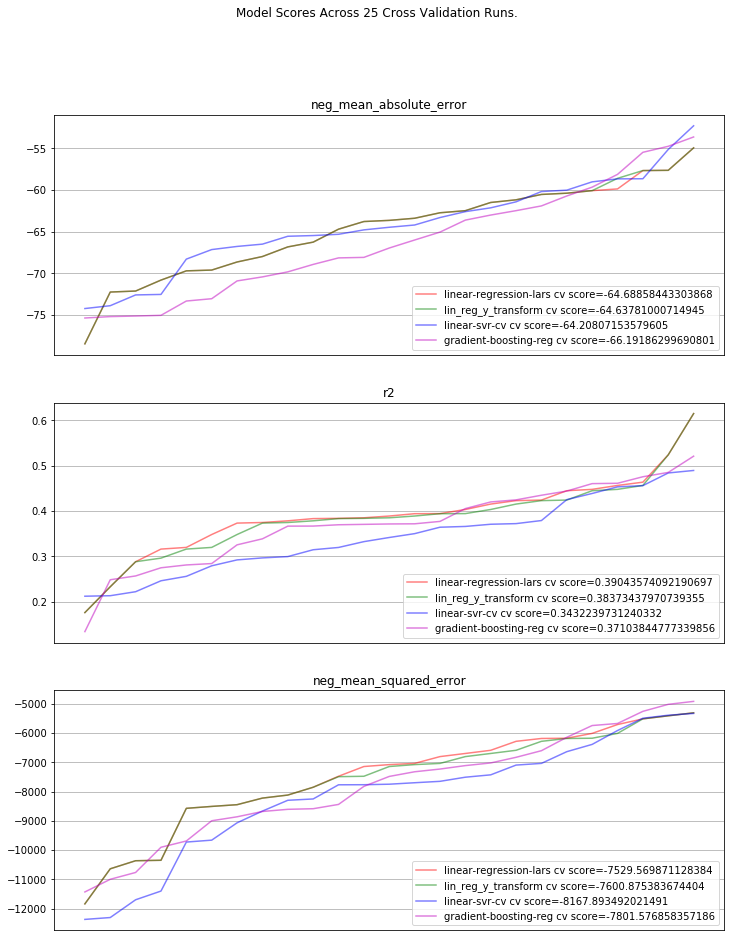

In [26]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [27]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [28]:
final_estimator_name='linear-regression-lars'

In [29]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [30]:
for name in estimator_dict.keys():
    print(name)
    printTestandCVScores(name,cv_score_dict_means)

linear-regression-lars
test set: negative-mse=-10320.056497238538
cv avg: neg_mean_squared_error= -7529.569871128386
cv avg: neg_mean_absolute_error= -64.68858443303868
cv avg: r2= 0.39043574092190686
coefficients:  [-5.32577954e+00  2.98033204e-02 -4.33428339e+00  2.86864330e+00
 -7.06724218e+00  2.01660388e+00  4.63219005e-01  4.72652384e+00
 -5.97423644e+00 -8.87851601e-01 -8.24919025e+00  3.60077300e+00
  2.29647847e+01  4.94718241e+00  1.15036271e+01 -5.93977608e+00
  1.05029097e+00 -5.76817819e+00  7.42574640e+00 -3.82612842e+00
  4.94498711e-01  5.02519538e+00 -1.68268226e+00 -9.70945136e+00
  4.68577860e-01  8.08188309e+00  2.37132444e+01 -6.13876210e+00
  8.50536267e-01 -1.26443025e+00 -1.30117369e+01  4.85204617e+00
  8.89810911e+00 -1.10838385e+01 -6.32360991e+00 -4.36518611e+00
  2.98355686e+00  3.44151942e+00  2.70961323e+00  2.93873109e+01
  1.38635041e+00 -2.35723205e+01  2.03067061e+01  4.37772622e+00
 -3.15632751e+01 -1.29814849e+01  1.15600745e+01 -1.54105357e+01
 -2.

In [31]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

KeyError: 'elastic-net'

In [ ]:
printTestandCVScores('lin_reg_Xy_transform',cv_score_dict_means)